In [31]:
%%time

#Ans 4a
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import random
from pprint import pprint


url="https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data"

colnames=('Header_1','Header_2','Header_3','Header_4','Header_5','Header_6','Header_7',
          'Header_8','Header_9','Header_10','Header_11','Header_12','Header_13','Header_14',
          'Header_15','Header_16','Header_17','Header_18','Header_19','Header_20','Header_21',
          'Header_22','Header_23','Header_24','Header_25','Header_26','Header_27','Header_28',
          'Header_29','Header_30','Header_31','Header_32','Header_33','Header_34','Header_35',
          'Header_36','Header_37','Header_38','Header_39','Header_40','Header_41','Header_42',
          'Header_43','Header_44','Header_45','Header_46','Header_47','Header_48','Header_49',
          'Header_50','Header_51','Header_52','Header_53','Header_54','Header_55','Header_56',
          'Header_57','Header_58')
df=pd.read_csv(url,names=colnames,sep = ' ',engine='python')
df.rename(columns = {'Header_58':'label'}, inplace = True)


#Functions used throughout

def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

    
# 1.2 Classify
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification


# 1.3 Potential splits?
def get_potential_splits(data, random_subspace):
    
    potential_splits = {}
    _, n_columns = data.shape
    column_indices = list(range(n_columns - 1))    # excluding the last column which is the label
    
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)
    
    for column_index in column_indices:          
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits


# 1.4 Lowest Overall Entropy?
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy


def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy


def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)
            
            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value


# 1.5 Split data
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above


# 2. Decision Tree Algorithm
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5, random_subspace=None):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree


# 3. Make predictions
# 3.1 One example
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

    
# 3.2 All examples of the test data
def decision_tree_predictions(test_df,tree):
    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions

def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df


# 2. Distinguish categorical and continuous features
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types


# 3. Accuracy
def calculate_accuracy(predictions, labels):
    predictions_correct = predictions == labels
    accuracy = predictions_correct.mean()
    
    return accuracy   



#random forest implementation

def bootstrapping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    random.seed(0)
    
    return df_bootstrapped

def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
    
    return forest

def random_forest_predictions(test_df,forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(test_df,tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    return random_forest_predictions

random.seed(0)
train_df, test_df = train_test_split(df, test_size=0.3)
forest = random_forest_algorithm(train_df, n_trees=10, n_bootstrap=3000, n_features=25, dt_max_depth=4)
predictions = random_forest_predictions(test_df,forest)
accuracy = calculate_accuracy(predictions, test_df.label)
final_accuracy=round((accuracy*100),5)
print("Accuracy of own implemented random forest is = {}".format(final_accuracy))


Accuracy of own implemented random forest is = 87.68116
Wall time: 3min 18s


Accuracy of the model using scikit:  0.945264986967854
Total runtime of the program is 3.8719887733459473 sec
[93.22328, 94.61338, 94.5265, 94.26586, 94.26586, 93.57081]
[1, 11, 21, 31, 41, 51]


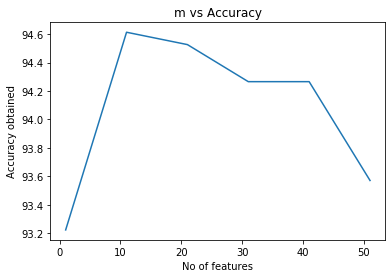

In [20]:
#Random forest implementation using scikit learn

import time
begin = time.time()
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import random
from sklearn import metrics
from sklearn.model_selection import train_test_split
url="https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data"

colnames=('Header_1','Header_2','Header_3','Header_4','Header_5','Header_6','Header_7',
          'Header_8','Header_9','Header_10','Header_11','Header_12','Header_13','Header_14',
          'Header_15','Header_16','Header_17','Header_18','Header_19','Header_20','Header_21',
          'Header_22','Header_23','Header_24','Header_25','Header_26','Header_27','Header_28',
          'Header_29','Header_30','Header_31','Header_32','Header_33','Header_34','Header_35',
          'Header_36','Header_37','Header_38','Header_39','Header_40','Header_41','Header_42',
          'Header_43','Header_44','Header_45','Header_46','Header_47','Header_48','Header_49',
          'Header_50','Header_51','Header_52','Header_53','Header_54','Header_55','Header_56',
          'Header_57','Header_58')
df=pd.read_csv(url,names=colnames,sep = ' ',engine='python')
df.rename(columns = {'Header_58':'label'}, inplace = True)

features=df
features=features.drop(labels='label', axis=1)
labels=df['label']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 42)



clf = RandomForestClassifier(n_estimators = 10,criterion='entropy',max_features=25,random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("Accuracy of the model using scikit: ", metrics.accuracy_score(y_test, y_pred))

time.sleep(1)

end = time.time()
print(f"Total runtime of the program is {end - begin} sec")

%matplotlib inline
a=[]
m=[]
for i in range(1,58,10):
    clf = RandomForestClassifier(n_estimators = 10,criterion='entropy',max_features=i,random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_cal=metrics.accuracy_score(y_test, y_pred)
    acc_cal=round((acc_cal*100),5)
    a.append(acc_cal)
    m.append(i)

print(a)
print(m)
import matplotlib.pyplot as plt
x=m
y=a
plt.plot(x, y)
plt.xlabel('No of features')
plt.ylabel('Accuracy obtained')
plt.title('m vs Accuracy')
plt.show()



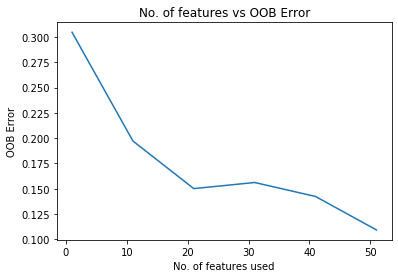

Wall time: 5min 12s
Parser   : 1.39 s


In [32]:
 %%time
%matplotlib inline


# Generate the "OOB error rate" vs. "max_features" plot

import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import random
from pprint import pprint


url="https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data"

colnames=('Header_1','Header_2','Header_3','Header_4','Header_5','Header_6','Header_7',
          'Header_8','Header_9','Header_10','Header_11','Header_12','Header_13','Header_14',
          'Header_15','Header_16','Header_17','Header_18','Header_19','Header_20','Header_21',
          'Header_22','Header_23','Header_24','Header_25','Header_26','Header_27','Header_28',
          'Header_29','Header_30','Header_31','Header_32','Header_33','Header_34','Header_35',
          'Header_36','Header_37','Header_38','Header_39','Header_40','Header_41','Header_42',
          'Header_43','Header_44','Header_45','Header_46','Header_47','Header_48','Header_49',
          'Header_50','Header_51','Header_52','Header_53','Header_54','Header_55','Header_56',
          'Header_57','Header_58')
df=pd.read_csv(url,names=colnames,sep = ' ',engine='python')
df.rename(columns = {'Header_58':'label'}, inplace = True)


#Functions used throughout

def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

    
# 1.2 Classify
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification


# 1.3 Potential splits?
def get_potential_splits(data, random_subspace):
    
    potential_splits = {}
    _, n_columns = data.shape
    column_indices = list(range(n_columns - 1))    # excluding the last column which is the label
    
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)
    
    for column_index in column_indices:          
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits


# 1.4 Lowest Overall Entropy?
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy


def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy


def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)
            
            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value


# 1.5 Split data
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above


# 2. Decision Tree Algorithm
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5, random_subspace=None):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree


# 3. Make predictions
# 3.1 One example
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

    
# 3.2 All examples of the test data
def decision_tree_predictions(test_df,tree):
    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions

def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df


# 2. Distinguish categorical and continuous features
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types


# 3. Accuracy
def calculate_accuracy(predictions, labels):
    predictions_correct = predictions == labels
    accuracy = predictions_correct.mean()
    
    return accuracy   



#random forest

random.seed(0)
train_df, test_df = train_test_split(df, test_size=0.3)


bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=3000)
df_bootstrapped = train_df.iloc[bootstrap_indices]
oob_indices = [i for i in range(len(train_df)) if i not in bootstrap_indices]
df_oob = pd.DataFrame(train_df.iloc[oob_indices].values)
df_oob.columns=colnames
df_oob.rename(columns = {'Header_58':'label'}, inplace = True)
    

def bootstrapping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    oob_indices = [i for i in range(len(train_df)) if i not in bootstrap_indices]
    df_oob = pd.DataFrame(train_df.iloc[oob_indices].values)
    df_oob.columns=colnames
    df_oob.rename(columns = {'Header_58':'label'}, inplace = True)
    
    return df_bootstrapped,df_oob


#calculating OOB score function
            
def oob_score(test_df,tree):
    mis_label = 0
    for i in range(len(test_df)):
        pred = decision_tree_predictions(test_df,tree)
        if pred[i] != test_df['label'][i]:
            mis_label += 1
            
    return mis_label / len(test_df)

def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    oob_ls = []
    for i in range(n_trees):
        df_bootstrapped ,df_oob= bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
        oob_error = oob_score(df_oob,tree)
        oob_ls.append(oob_error)
    oob=(np.mean(oob_ls))
    
    return forest,oob

def random_forest_predictions(test_df,forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(test_df,tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    return random_forest_predictions


x=[]
features=[]

for i in range(1,58,10):
    
    forest,y = random_forest_algorithm(test_df, n_trees=4, n_bootstrap=3000, n_features=i, dt_max_depth=3)
    
    x.append(y)
    features.append(i)

#graph plot between m and oob error
import matplotlib.pyplot as plt

oob_value=x
 

x = features
y = oob_value
plt.plot(x, y)
 

plt.xlabel('No. of features used')

plt.ylabel('OOB Error')
 
plt.title('No. of features vs OOB Error')
plt.show()


[0.1681159420289855, 0.17028985507246375, 0.11811594202898545, 0.1427536231884058, 0.1289855072463768, 0.15000000000000002]
[1, 11, 21, 31, 41, 51]


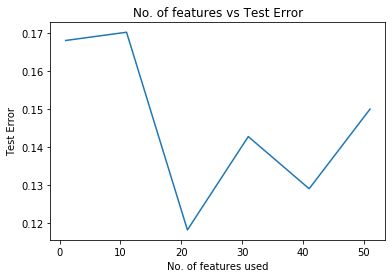

Wall time: 49min 18s
Parser   : 192 ms


In [36]:
 %%time
features=[]
err=[]
for i in range(1,58,10):
    
    forest,y = random_forest_algorithm(train_df, n_trees=4, n_bootstrap=3000, n_features=i, dt_max_depth=3)
    predictions = random_forest_predictions(test_df,forest)
    accuracy = calculate_accuracy(predictions, test_df.label)
    err.append(1-accuracy)
    features.append(i)

print(err)
print(features)
#graph plot between m and test error
import matplotlib.pyplot as plt
 

x = features
y = err
plt.plot(x, y)
 

plt.xlabel('No. of features used')

plt.ylabel('Test Error')
 

plt.title('No. of features vs Test Error')
plt.show()

